In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertModel
import torch

/Users/danielcoker/Documents/School/500 Level/Final Year Project/Emergency Management System/Code Playground/SVM  Playground/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from descriptions import descriptions

category_names = {0: "Fire", 1: "Crime", 2: "Health"}

for key, item in descriptions.items():
    print(key, len(item))

data = {
    "Description": [],
    "IncidentCategory": []
}

print("====================")

for key, item in descriptions.items():
    _item_list = list(set(item))
    data["Description"] += _item_list

    print(key, len(_item_list))

    if key == "fire":
        category_key = 0
    elif key == "crime":
        category_key = 1
    elif key == "health":
        category_key = 2
    else:
        raise Exception("Invalid key")

    data["IncidentCategory"] += [category_key for _ in range(len(_item_list))]

print("Total", len(data["Description"]))

health 281
fire 274
crime 255
health 266
fire 244
crime 212
Total 722


In [4]:
import string

def remove_punctuation(input_string):
    # Make a translation table that maps all punctuation characters to None
    translator = str.maketrans("", "", string.punctuation)

    # Apply the translation table to the input string
    result = input_string.translate(translator)

    return result

In [5]:
df = pd.DataFrame(data)

In [6]:
df

,Description,IncidentCategory
0,"Near the entrance, a student collapses and app...",2
1,"In the theater workshop, a prop falls and inju...",2
2,Panic ensues as a health crisis unfolds in the...,2
3,"During a football game, a player suffers a con...",2
4,"At the staircase, a student falls and hits the...",2
...,...,...
717,Suspicious social media account impersonating ...,1
718,Suspicious individual loitering near restricte...,1
719,Suspicious individual attempting to enter a re...,1
720,Student reports feeling threatened by online p...,1


In [7]:
# Apply remove_punctuation function
df['Description'] = df['Description'].apply(remove_punctuation)

# Lowercase
df['Description'] = df['Description'].str.lower()

# Tokenization
df['Description'] = df['Description'].apply(nltk.word_tokenize)

# Stop Word Removal
stop_words = set(stopwords.words('english'))
df['Description'] = df['Description'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Stemming
stemmer = PorterStemmer()
df['Description'] = df['Description'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])

# Join the tokens back into a single string
df['Description'] = df['Description'].apply(' '.join)

# BERT Tokenization and Embeddings
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [8]:
df

,Description,IncidentCategory
0,near entranc student collaps appear unrespons ...,2
1,theater workshop prop fall injur student foot ...,2
2,panic ensu health crisi unfold gym rush alert ...,2
3,footbal game player suffer concuss headon coll...,2
4,staircas student fall hit head there visibl in...,2
...,...,...
717,suspici social media account imperson univers ...,1
718,suspici individu loiter near restrict research...,1
719,suspici individu attempt enter restrict resear...,1
720,student report feel threaten onlin predat atte...,1


In [9]:
# BERT Tokenization and Embeddings
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [13]:
# Function to get BERT embeddings for a sentence
def get_bert_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)

    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

In [12]:
# Apply BERT embeddings to each description
df['BERT_Embeddings'] = df['Description'].apply(get_bert_embeddings)


In [14]:
df

,Description,IncidentCategory,BERT_Embeddings
0,near entranc student collaps appear unrespons ...,2,"[-0.26171616, -0.18315972, 0.23262438, -0.0474..."
1,theater workshop prop fall injur student foot ...,2,"[-0.16842484, -0.10688164, 0.040714215, -0.032..."
2,panic ensu health crisi unfold gym rush alert ...,2,"[0.027375655, -0.07856429, 0.36883605, 0.07116..."
3,footbal game player suffer concuss headon coll...,2,"[-0.16802306, -0.17666484, 0.052773118, -0.123..."
4,staircas student fall hit head there visibl in...,2,"[-0.33326006, -0.21782272, 0.28506717, -0.0632..."
...,...,...,...
717,suspici social media account imperson univers ...,1,"[0.0035406067, -0.19019249, 0.23692372, 0.1177..."
718,suspici individu loiter near restrict research...,1,"[-0.093579255, -0.19043131, 0.26958585, -0.017..."
719,suspici individu attempt enter restrict resear...,1,"[-0.04762668, -0.16693522, 0.24332741, 0.04132..."
720,student report feel threaten onlin predat atte...,1,"[0.0051218816, -0.13141276, 0.24435623, 0.0801..."


In [15]:
# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['BERT_Embeddings'].tolist(),
    df['IncidentCategory'],
    test_size=0.2,
    random_state=42,
)

In [17]:
# Train the SVM Model
svm_classifier = SVC(kernel='linear', C=0.5, random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(C=0.5, kernel='linear', random_state=42)

In [18]:
# Make predictions on the test set
svm_predictions = svm_classifier.predict(X_test)

In [19]:
# Evaluate the model
report = classification_report(y_test, svm_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        45
           1       1.00      0.85      0.92        41
           2       0.95      0.98      0.97        59

    accuracy                           0.95       145
   macro avg       0.96      0.95      0.95       145
weighted avg       0.95      0.95      0.95       145



In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, svm_predictions)

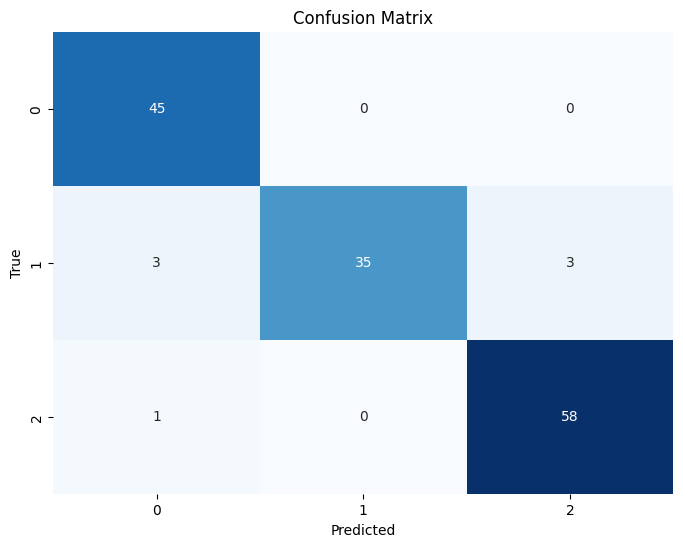

In [22]:
# category_names = {0: "Fire", 1: "Crime", 2: "Health"}

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
# Function to get BERT embeddings for user input
def get_user_input_embeddings(user_input):
    user_input_processed = remove_punctuation(user_input.lower())
    user_input_tokens = nltk.word_tokenize(user_input_processed)
    user_input_tokens = [word for word in user_input_tokens if word not in stop_words]
    user_input_tokens = [stemmer.stem(word) for word in user_input_tokens]
    user_input_string = ' '.join(user_input_tokens)
    user_input_embedding = get_bert_embeddings(user_input_string)

    return user_input_embedding

In [28]:
# Test Input

"""
Fire broke out in the lab
A student is running dubs at T.I Francis, send the sheriffs
Accident happened at engineering building abeg.
I fell from the stairs while cleaning now I can't feel my legs, help!!
"""


user_input = "Accident happened at engineering building abeg."

# Get BERT embeddings for user input
user_input_embedding = get_user_input_embeddings(user_input)

# Make prediction using the trained SVM model
user_prediction = svm_classifier.predict([user_input_embedding])

print(user_prediction)

predicted_category_name = category_names[user_prediction[0]]

# Display the prediction
print(
    "Predicted Incident Category:",
    f"{predicted_category_name} ({user_prediction[0]})",
)

[2]
Predicted Incident Category: Health (2)
